# Using STDP to classify the MNIST dataset

In [2]:
%load_ext autoreload
%autoreload 2
# basic libraries
import os
import sys
import time
import numpy as np
import pandas as pd

# graphics libraries
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import ipywidgets as widgets
import jupyterlab_widgets as lab
from IPython.display import display
import logging
logging.getLogger('matplotlib.font_manager').disabled = True
%config InlineBackend.figure_format='retina'
# use NMA plot style
#plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")
plt.style.use('seaborn-v0_8')
my_layout = widgets.Layout()
my_layout.width = '620px'

#machine Learning libraries
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import snntorch as snn
import snntorch.spikeplot as splt
from snntorch import utils
from snntorch import spikegen


#import from my scripts
main_dir = os.getcwd()
if main_dir not in sys.path:
    print('Adding the folder for the modules')
    sys.path.append(main_dir)
import importlib

importlib.reload(importlib.import_module('snn_experiments'))
importlib.reload(importlib.import_module('snn_plot_utils'))
importlib.reload(importlib.import_module('snn_models'))
importlib.reload(importlib.import_module('snn_datasets'))

from snn_experiments import *
from snn_plot_utils import *
from snn_models import *
from snn_datasets import *


# show packages versions for python, numpy, and ipywidgets
print("Python: ", sys.version)
print("Numpy: ", np.__version__)
print("Pandas: ", pd.__version__)
print("jupyterlab_widgets: ", lab.__version__ )
print("IPywidgets: ", widgets.__version__)
print("Torch: ", torch.__version__)
print("Snntorch: ", snn.__version__) # version 0.6.4 before update, current version online 0.7.0

Python:  3.11.5 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:26:23) [MSC v.1916 64 bit (AMD64)]
Numpy:  1.26.0
Pandas:  2.1.1
jupyterlab_widgets:  3.0.9
IPywidgets:  8.0.4
Torch:  2.1.0
Snntorch:  0.6.4


# 1. Intro with artificial correlated data


## 1.1 Spotting correlated input with synaptic lif and external STDP class

Simulation time: 62.25 seconds


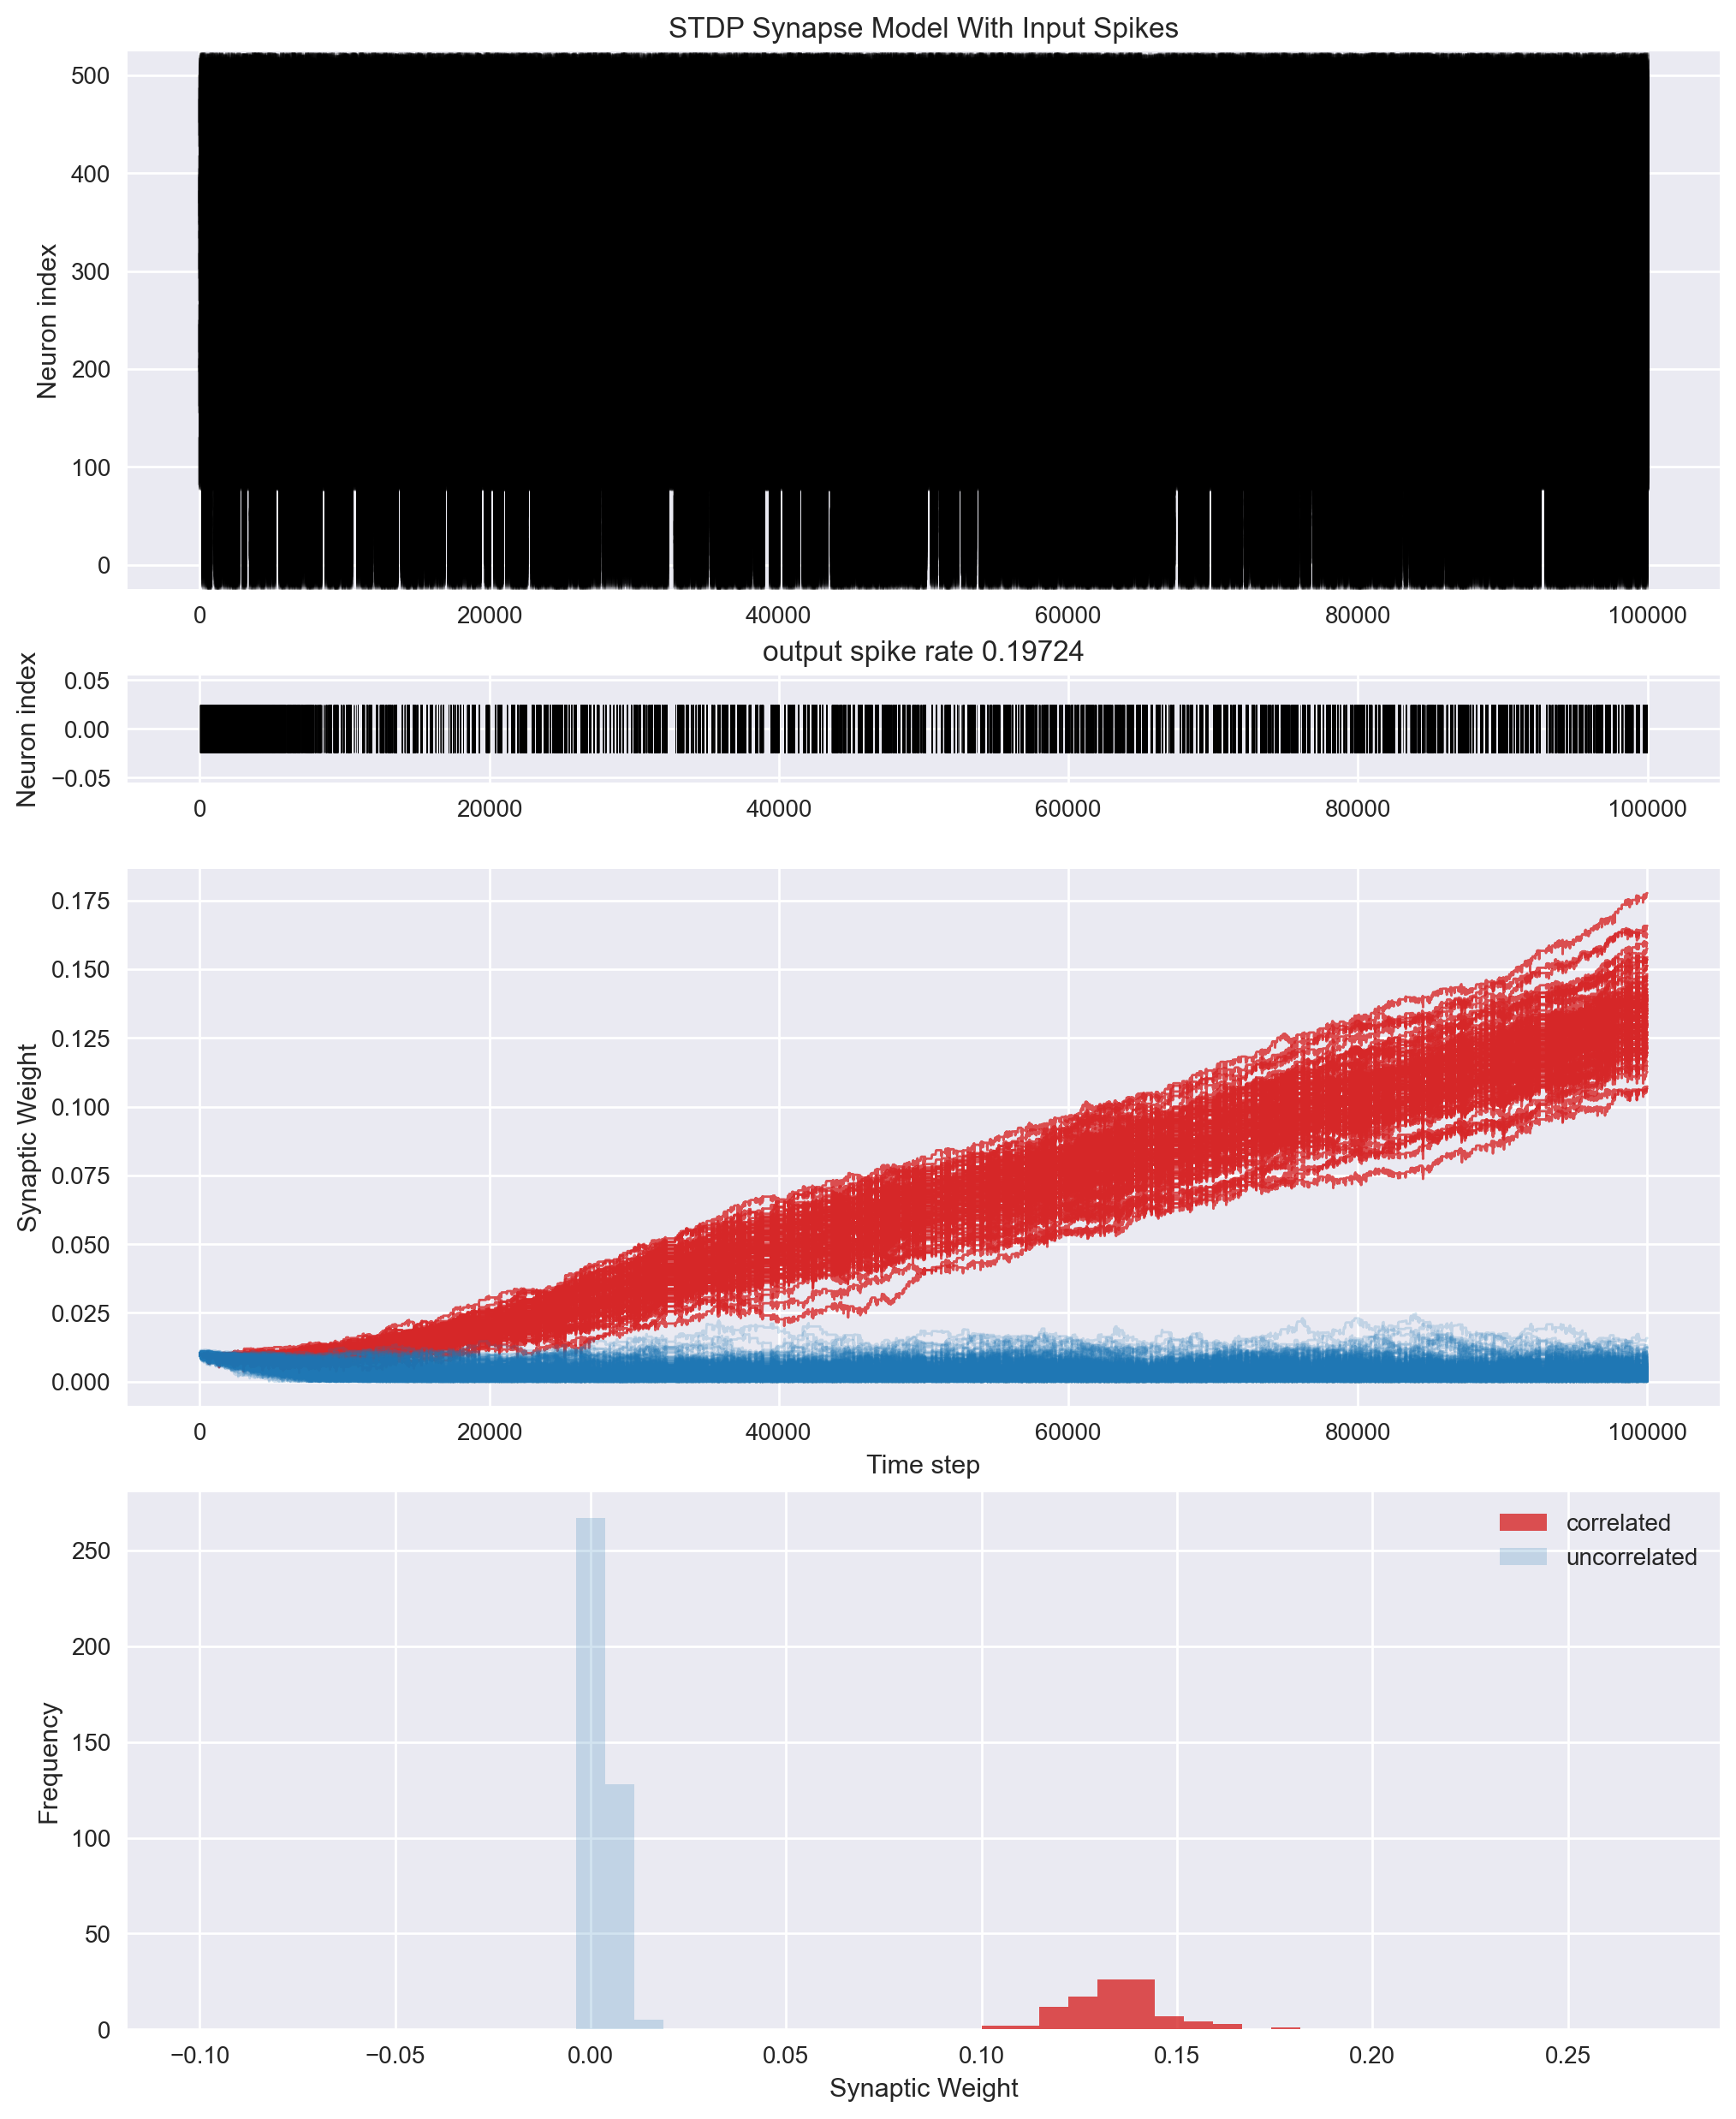

In [6]:
# basic variables
N_pre = 500
N_pre_correlated = 100
N_post = 1
num_steps = 100000

# parameters of the simulation
pars = default_pars(type_parameters='simple', 
                    w_init_value = 0.1,
                    A_minus = 0.0088 * 0.024,
                    A_plus = 0.008 * 0.024,)
dt = pars['dt']
time_steps = np.arange(num_steps) * dt
rate = 0.01

# generate the injected spikes with some correlation
cur_in_numpy,_ = random_shifted_trains(dt, num_steps, N_pre, N_pre_correlated , rate = rate, shift_values=[-20,20]) 
cur_in = torch.from_numpy(cur_in_numpy)

# initialize the weights
W = np.random.rand(N_post, N_pre) * pars['w_init_value'] / 100
W = weight_initializer(pars, N_post, I=cur_in_numpy, type_init=2) * pars['w_init_value']  #* np.random.rand(N_post,N_pre) # noise added to appreciate different STDP dynamics
W = torch.from_numpy(W)

# initialize postsynaptic neurons
beta = np.exp(-pars['dt']/pars['tau_m'] *(1+pars['max_g'])) # or 0.8
alpha = np.exp(-pars['dt']/pars['tau_syn_exc']) #or 0.9
rm = 'zero' if pars['hard_reset'] else 'subtract' 
thr = pars['threshold']
post_neurons = [ snn.Synaptic(alpha = alpha, beta = beta, threshold=thr, reset_mechanism=rm) for _ in range(N_post)]

# initialize the tracking variables
mem_record = np.zeros((num_steps+1, N_post))
spk_record = np.zeros((num_steps+1, N_post))
cond_record = np.zeros((num_steps+1, N_post))
mem_record[0,:] = np.asarray([0 for i in range(N_post)])
spk_record[0,:] = np.asarray([0 for i in range(N_post)])
cond_record[0,:] = np.asarray([0 for i in range(N_post)])

# intialize the synapses
my_synapses = STDP_synapse(pars, N_pre, N_post, W_init = W ) # this works even if now W is a tensor!

# run the simulation
start_time = time.time()
for step in range(num_steps):
    # current injected at this time step
    pre_syn_spikes = cur_in[step]
    cur_in_step = W @ pre_syn_spikes

    #spike generated by the layer
    for i in range(N_post):
        spk, cond, mem = post_neurons[i](cur_in_step[i], cond_record[step, i], mem_record[step,i])
        spk_record[step+1,i] = spk
        mem_record[step+1,i] = mem
        cond_record[step+1,i] = cond

    post_syn_spk = spk_record[step+1,:]
    
    # update the weights
    my_synapses.update_weights([pre_syn_spikes.detach().numpy(),post_syn_spk])
    W = my_synapses.W

print(f"Simulation time: {time.time() - start_time:.2f} seconds")

# convert the results to torch tensors
mem_record = torch.from_numpy(mem_record[1:,:])
spk_record = torch.from_numpy(spk_record[1:,:])

weight_history = my_synapses.get_records()['W'][1:,0,:]
plot_raster_weight_distr(cur_in, spk_record, weight_history, N_pre_correlated)



## 1.2 Spotting correlated input with an SNN with 1 FC layer, Synaptic Neuron, classic STDP

Forward pass time : --- 64.67 seconds ---


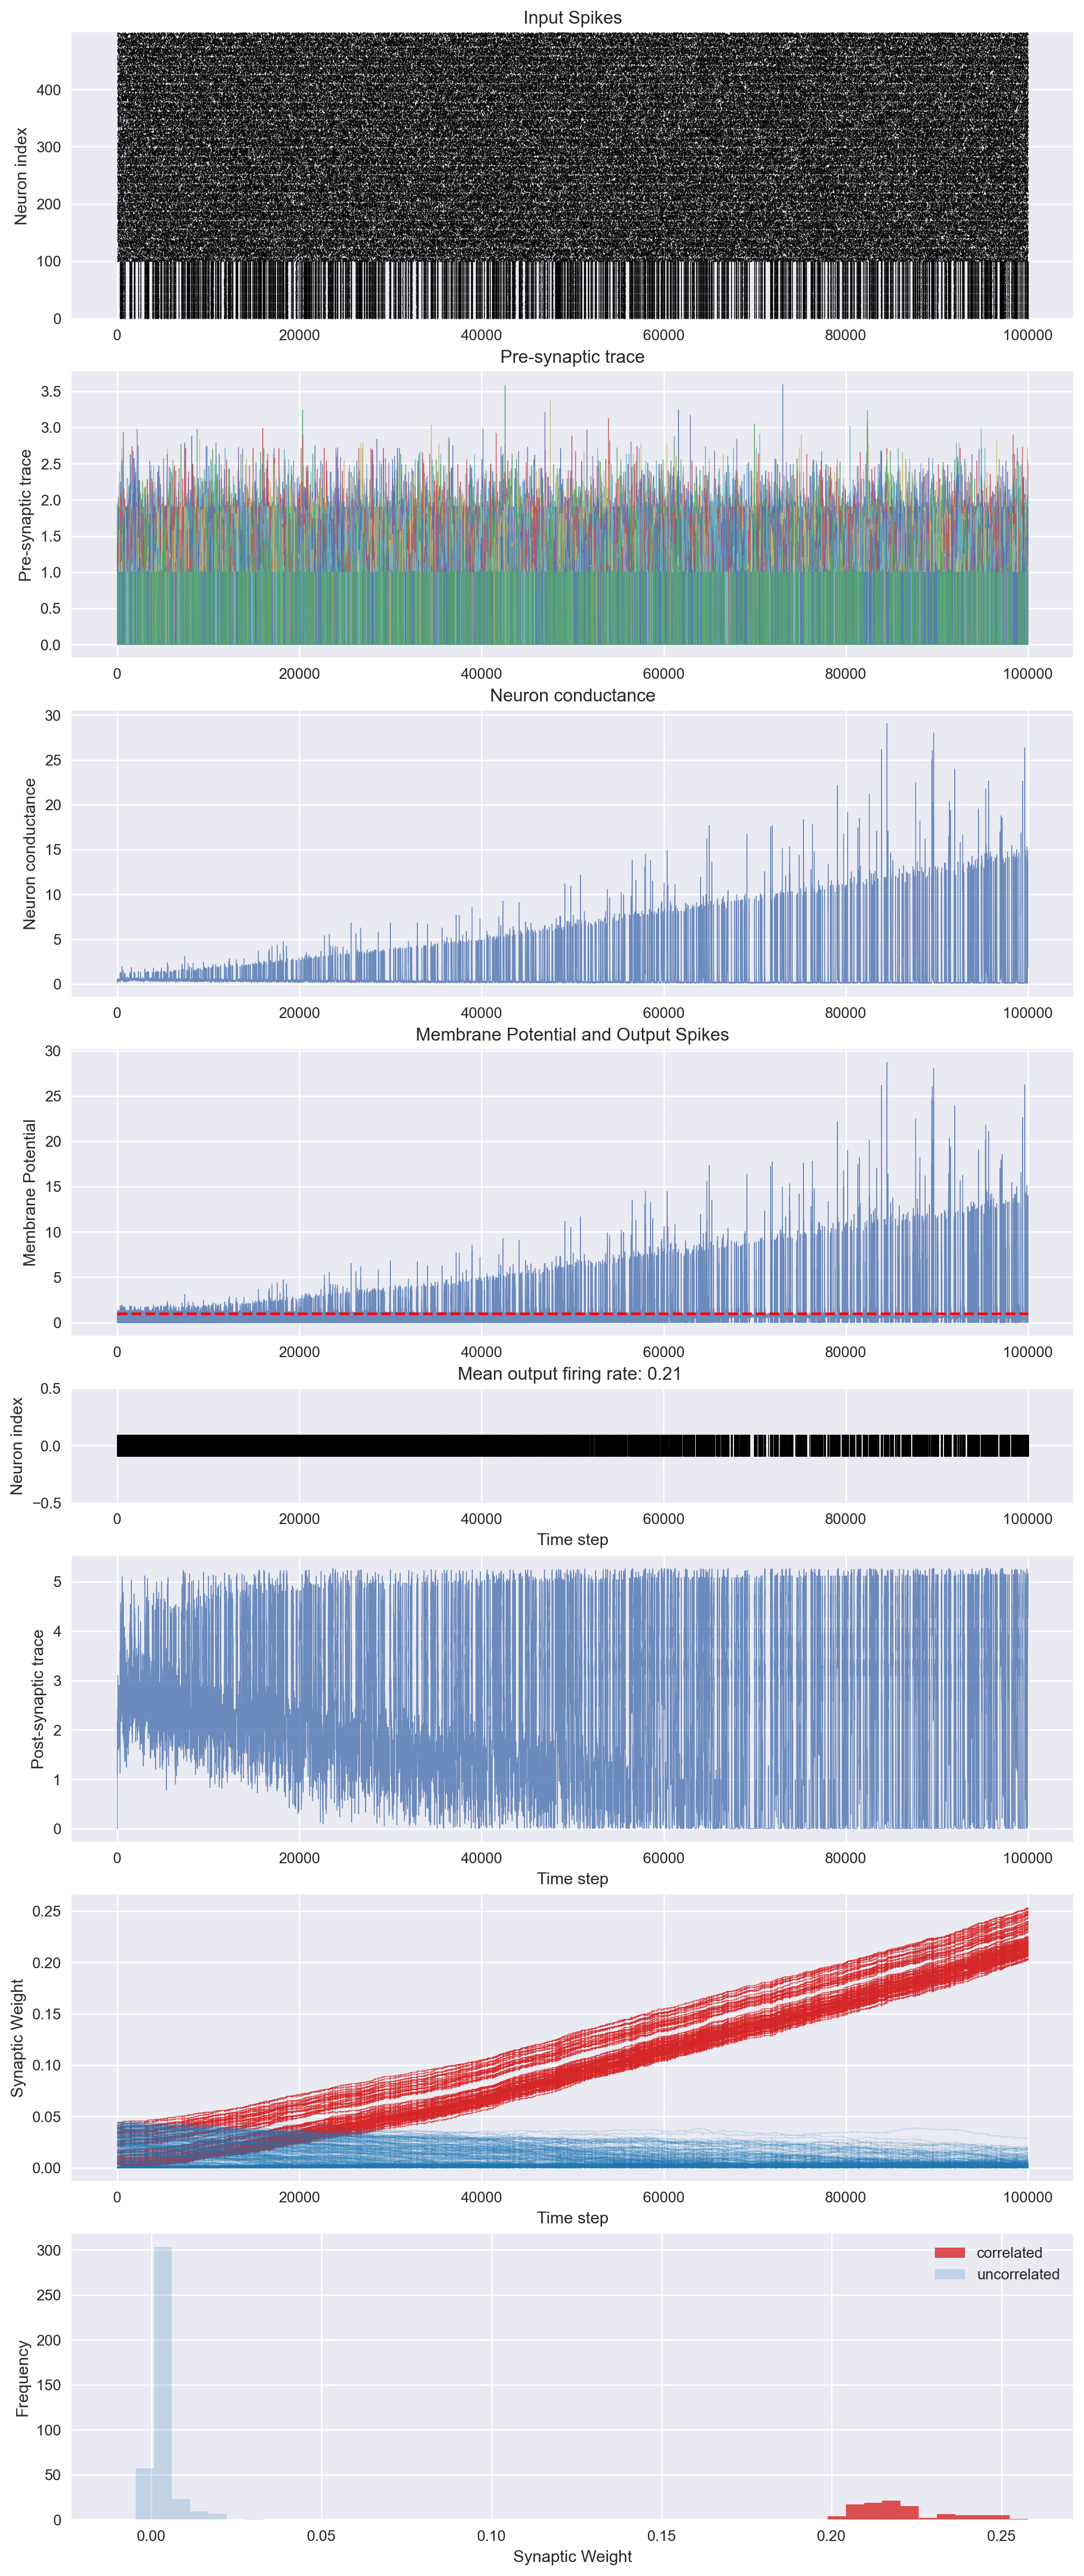

In [10]:
# basic variables
# basic variables
N_pre = 500
N_pre_correlated = 100
N_post = 1
num_steps = 100000
batch_size = 0 # for the moment we do not use batch size
rate = 0.01

class synaptic_stdp(nn.Module):

    def __init__(self, pars, N_pre, N_post = 1):
        super(synaptic_stdp, self).__init__()
        self.pars = pars
        self.alpha = pars.get('alpha', 0.9)
        self.beta = pars.get('beta', 0.8)
        self.w_max = pars.get('w_max', 1.0)
        self.w_min = pars.get('w_min', 0.0)
        self.fc = nn.Linear(N_pre, N_post, bias=False)
        # clamp the weight to positive values
        self.fc.weight.data = torch.clamp(self.fc.weight.data, min=self.w_min, max=self.w_max)
        # set the weight of the layer
        #W_init = weight_initializer(pars, N_pre, N_post, type_init = 3, tensor = True)
        #self.fc.weight = nn.Parameter(W_init)
        reset_mechanism = 'zero' if pars['hard_reset'] else 'subtract'
        self.lif = snn.Synaptic(alpha = self.alpha, beta = self.beta, threshold = pars['threshold'], reset_mechanism = reset_mechanism)

    def forward(self, x):
        # initiliaze the membrane potential and the spike
        cond, mem = self.lif.init_synaptic()

        #tracking variables
        mem_rec = []
        spk_rec = []
        cond_rec = []
        # dovrei inizializzare tutto o come liste o come tensori...
        pre_syn_traces = generate_traces(self.pars, x)
        post_syn_traces = torch.zeros((x.shape[0]+1, N_post))
        weight_history = torch.zeros((x.shape[0]+1, N_post, N_pre))
        weight_history[0,:,:] = self.fc.weight.data

        for step in range(x.shape[0]):
            # run the fc layer
            cur_step = self.fc(x[step])
            # run thw lif neuron
            spk, cond,  mem = self.lif(cur_step, cond, mem)

            # store the membrane potential and the spike
            mem_rec.append(mem)
            spk_rec.append(spk)
            cond_rec.append(cond)

            # updatae post synaptic traces
            beta_minus = self.pars.get('beta_minus',0.9)
            post_syn_traces[step+1, :] = beta_minus*post_syn_traces[step, :] + spk

            # update the weights
            weight_history[step,:,:] = self.fc.weight.data
            A_plus, A_minus = self.pars['A_plus'], self.pars['A_minus']
            LTP = A_plus * torch.outer(spk, pre_syn_traces[step,:]) 
            LTD = A_minus * torch.outer(post_syn_traces[step+1,:], x[step])
            self.fc.weight.data = self.fc.weight.data + LTP - LTD
            # hard constrain on the weights
            self.fc.weight.data = torch.clamp(self.fc.weight.data, min=self.w_min, max=self.w_max)


        post_syn_traces = post_syn_traces[:-1,:]
        weight_history = weight_history[:-1,:,:]

        self.records = {'mem': torch.stack(mem_rec), 
                        'spk': torch.stack(spk_rec), 
                        'cond':  torch.stack(cond_rec), 
                        'pre_trace': pre_syn_traces, 
                        'post_trace': post_syn_traces, 
                        'W': weight_history}

        return 
    
    



# parameters of the simulation
pars = default_pars(type_parameters='simple', 
                    w_init_value = 0.012,
                    alpha = 0.9,
                    beta = 0.8,
                    threshold = 1.0,
                    hard_reset = True,
                    A_minus = 0.0088 * 0.024,
                    A_plus = 0.008 * 0.024,
                    beta_minus = 0.9,
                    beta_plus = 0.9)
dt = pars['dt']

# generate the input spikes
cur_in_numpy,_ = random_shifted_trains(dt, num_steps, N_pre, N_pre_correlated , rate = rate, shift_values=[-5,5]) 
cur_in = torch.from_numpy(cur_in_numpy)
cur_in = cur_in.to(dtype = torch.float32, device = device)

# intitilize the model
my_model = synaptic_stdp(pars, N_pre, N_post)

# run the simulation
#my_model.train()
start_time = time.time()
my_model.forward(cur_in)
print(f"Forward pass time : --- {(time.time() - start_time):.2f} seconds ---")
mem_rec, spk_rec, cond_rec, pre_trace, post_trace, weight_history = my_model.records['mem'], my_model.records['spk'], my_model.records['cond'], my_model.records['pre_trace'], my_model.records['post_trace'], my_model.records['W']

# plot results
plot_results_32(dt, cur_in, pre_trace.detach().numpy(), 
                cond_rec.detach().numpy(), 
                mem_rec.detach().numpy(), 
                spk_rec.detach().numpy(), 
                post_trace.detach().numpy(), 
                weight_history.detach().numpy(), N_pre, N_pre_correlated, N_post, num_steps)


## 1.3 Spotting correlated input with the general SNN that we will use also for the MNIST

Forward pass time : --- 57.52 seconds ---


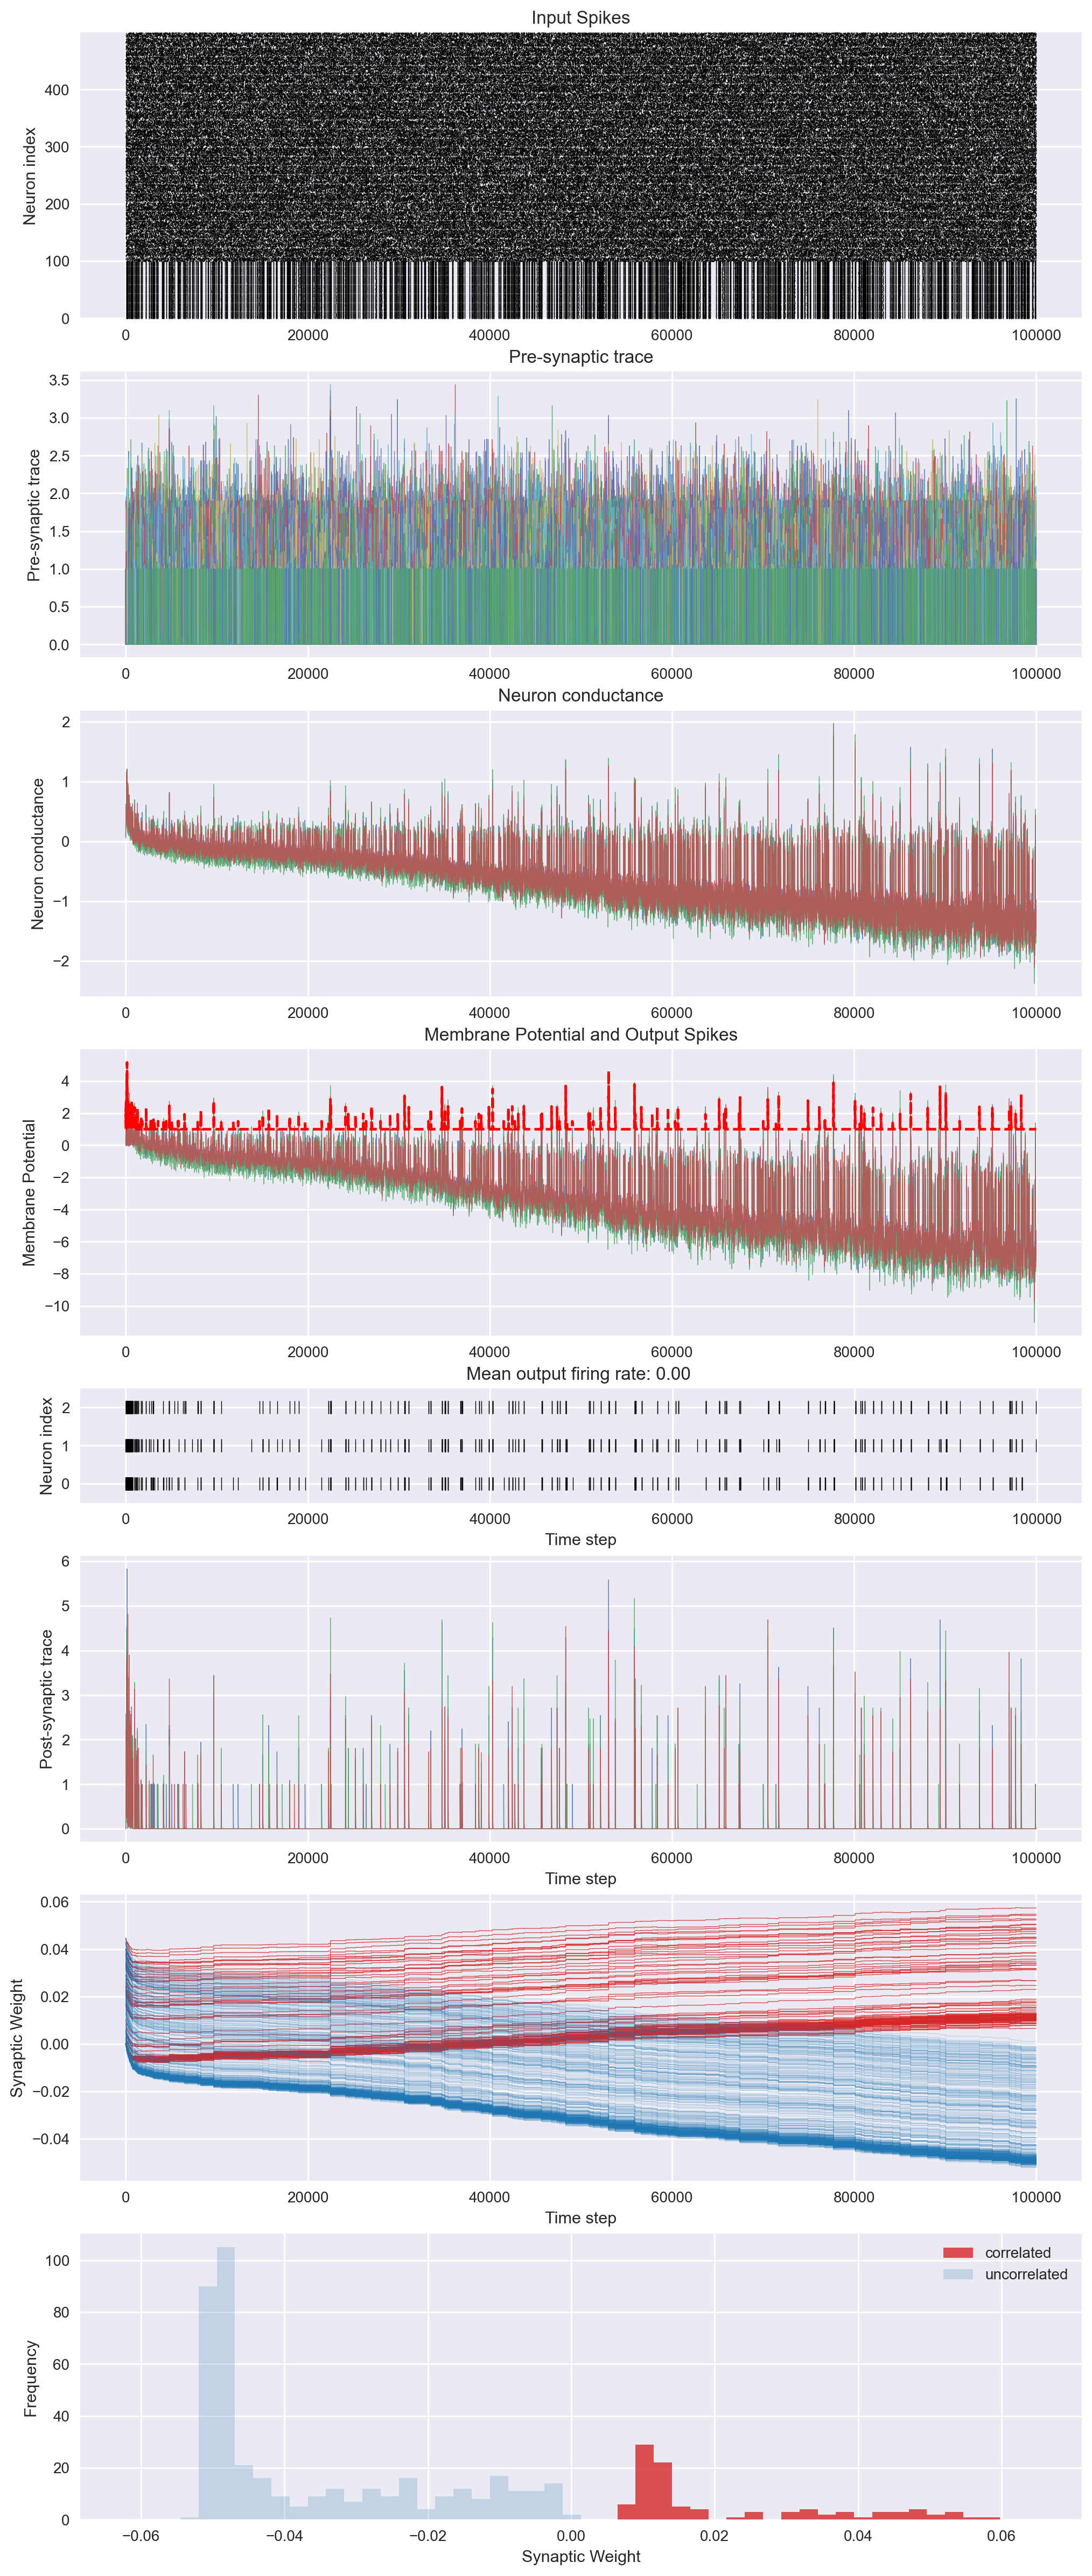

In [34]:
num_steps = 100000
N_pre = 500
N_pre_correlated = 100
rate = 0.01
dt = 1
N_post = 3

pars = mnist_pars(
    STDP_type = 'offset',
    STDP_offset = 0.7,
    num_steps = num_steps,
    A_minus = 0.0088*0.024, 
    A_plus = 0.008*0.024,
    reset_mechanism = 'subtract',
    dynamic_threshold = True,
    tau_theta = 20, 
    theta_add = 0.5,
    refractory_period = False,
    ref_time = 2,
    lateral_inhibition = False,
    lateral_inhibition_strength = 0.1,
)

# create the input spike trains
cur_in_numpy_base,_ = random_shifted_trains(dt, num_steps, N_pre, N_pre_correlated , rate = rate, shift_values=[-5,5]) 
# add a batch dimension to cur_in_numpy
cur_in_numpy = cur_in_numpy_base[:,None,:]
cur_in = torch.from_numpy(cur_in_numpy)
cur_in_base = torch.from_numpy(cur_in_numpy_base)
cur_in = cur_in.to(dtype = torch.float32, device = device)

model = snn_mnist(pars, N_pre, N_post)
model.eval()

start_time = time.time()
model.forward(cur_in)
print(f"Forward pass time : --- {(time.time() - start_time):.2f} seconds ---")

pre_trace = model.get_records()['pre_trace']
cond_rec = model.get_records()['syn']
mem_rec = model.get_records()['mem']
threshold_rec = model.get_records()['threshold']
spk_rec = model.get_records()['spk']
post_trace = model.get_records()['post_trace']
weight_history = model.get_records()['W']

plot_results_32(dt, cur_in_base, pre_trace, cond_rec, mem_rec, torch.from_numpy(spk_rec), post_trace, weight_history, N_pre, N_pre_correlated, N_post, num_steps, threshold_rec = threshold_rec)

# 2. Digit recognition

## 2.1 MNIST encoding in spike trains

In [3]:
# parameters of the simulation       
batch_size = 50
num_steps = 100

# Create the datasets
mnist_train = rate_encoded_mnist(batch_size, num_steps=num_steps, gain=1, train=True, my_seed = 42)
mnist_test = rate_encoded_mnist(batch_size, num_steps=num_steps, gain=1, train=False, my_seed = 42)

# Get the dataloaders
train_loader, val_loader = mnist_train.get_loader()
test_loader = mnist_test.get_loader()

# get the subset loader
subset_loader = mnist_train.get_subset(subset=100)
subset_loader_test = mnist_test.get_subset(subset=100)

# check the shape in the loaders and the loader length
data = iter(train_loader)
data_it, targets_it = next(data)
print(f"Size of a batch of spike data is {data_it.size()}")
print(f"Length of the train_loader is {len(train_loader)}")

data = iter(val_loader)
data_it, targets_it = next(data)
print(f"Size of a batch of spike data is {data_it.size()}")
print(f"Length of the val_loader is {len(val_loader)}")

# check the shape in the subset loader and the loader length
data = iter(subset_loader)
data_it, targets_it = next(data)
print(f"Size of a batch of spike data is {data_it.size()}")
print(f"Length of the subset_loader is {len(subset_loader)}")


Size of a batch of spike data is torch.Size([100, 50, 784])
Length of the train_loader is 1000
Size of a batch of spike data is torch.Size([100, 50, 784])
Length of the val_loader is 200
Size of a batch of spike data is torch.Size([100, 50, 784])
Length of the subset_loader is 12


## 2.2 Some preliminaries 

### Class assignment function


In [6]:
num_epochs = 2
num_steps = 100
min_spk_number = 1
pars = mnist_pars(
    STDP_type = 'classic',
    num_steps = num_steps,
    A_minus = 0.0088 ,
    A_plus = 0.008 ,
    reset_mechanism = 'subtract',
    dynamic_threshold = False,
    tau_theta = 5, 
    theta_add = 0.1,
    refractory_period = False,
    ref_time = 2,
    lateral_inhibition = False,
    lateral_inhibition_strength = 1,
    gain = 0.1,
)
N_pre = 28*28
N_post = 10
model = snn_mnist(pars, N_pre, N_post)

assignments, df = assign_neurons_to_classes(model, val_loader = subset_loader)

print(assignments)
display(df)


[0 0 0 0 0 0 0 0 0 0]


0          1          2          3          4  \
0              0.998793   0.987468   0.997188   0.997288   0.991356   
1              0.996379   0.988354   0.994219   0.991864   0.990000   
2              0.996724   0.989494   0.995938   0.994576   0.991525   
3              0.997414   0.989873   0.996875   0.995932   0.992542   
4              0.998448   0.988861   0.997656   0.996271   0.992034   
5              0.998621   0.988354   0.996719   0.996610   0.991695   
6              0.997414   0.988101   0.994688   0.994237   0.990847   
7              0.997069   0.987975   0.995313   0.992203   0.989831   
8              0.998448   0.988354   0.996719   0.995085   0.991695   
9              0.998103   0.988228   0.996719   0.995424   0.991017   
sample_count  58.000000  79.000000  64.000000  59.000000  59.000000   

                      5          6          7          8          9  max_index  
0              0.993333   0.995926   0.990645   0.996122   0.990615          0  
1              0.991176   0.990556   0.990161   0.991429   0.989846          0  
2              0.992353   0.992963   0.990968   0.995102   0.990769          0  
3              0.992353   0.995370   0.993548   0.996939   0.991692          0  
4              0.993137   0.996481   0.992258   0.997143   0.991846          0  
5              0.992745   0.994815   0.990645   0.993265   0.990769          0  
6              0.991569   0.992593   0.989677   0.991224   0.990615          0  
7              0.990784   0.992037   0.990484   0.992041   0.989846          0  
8              0.992353   0.996111   0.990645   0.994898   0.990769          0  
9              0.991961   0.993889   0.990323   0.994898   0.990308          0  
sample_count  51.000000  54.000000  62.000000  49.000000  65.000000          1

### Evaluation Function

In [12]:
# modify the assignments to have random classes
for i in range(N_post):
    assignments[i] = np.random.randint(0, 9)

# classify the data in the subset loader
test_accuracy = classify_test_set(model, subset_loader, assignments)

display(test_accuracy)

0.11

### Training function

In [29]:
# gets all the target from the subset_loader
targets = torch.tensor([])
for data, target in subset_loader:
    targets = torch.cat((targets, target))

targets = targets.numpy()

# print the ratio of most represented class
most_represented_class = np.argmax([np.sum(targets == i) for i in range(10)])
print(f"The most represented class is class {most_represented_class} with a ratio of {np.sum(targets == most_represented_class)/len(targets)}")

The most represented class is class 1 with a ratio of 0.13166666666666665


In [39]:
num_epochs = 2
min_spk_number = 1

pars = mnist_pars(
    STDP_type = 'classic',
    num_steps = num_steps,
    A_minus = 0.00011,
    A_plus = 0.0001 ,
    reset_mechanism = 'zero',
    dynamic_threshold = True,
    tau_theta = 20, 
    theta_add = 0.25,
    refractory_period = False,
    ref_time = 2,
    lateral_inhibition = True,
    lateral_inhibition_strength = 0.1,
    gain = 0.1,
    use_min_spk_number = False,
    min_spk_number = min_spk_number,
)

N_pre = 28*28
N_post = 10
model = snn_mnist(pars, N_pre, N_post)

# Train the model
start_time = time.time()
model = train_model(model, 
                    train_loader = subset_loader, 
                    val_loader = subset_loader,
                    num_epochs = num_epochs, 
                    )
print(f' The total training time is {time.time() - start_time:.2f} seconds')

# print the ram size of records_full
print(f"The size of records is {sys.getsizeof(model.get_records())/1e3:.2f} KB")



100%|███████████████████████████████████████████████████| 12/12 [00:07<00:00,  1.59batch/s, accuracy=0.0983, time=7.57s]

 The total training time is 14.31 seconds
The size of records is 0.27 KB


In [42]:
# plot the results
model.plot_simulation_records()

interactive(children=(IntSlider(value=0, description='Neuron index', layout=Layout(width='600px'), max=9, styl…

In [35]:
print(f'the forward count is {model.forward_count}')
print(f'the batch size is {model.batch_size}')
print(f'the num steps is {model.num_steps}')
print(f'The total simulation time is {model.tot_sim_time:.2f} seconds')
print(f'subsampling rate of records is {model.t}')

# check that the records have all the correct shapes
records = model.get_records()
for key in records.keys():
    print(f'{key} has shape {records[key].shape}')

the forward count is 24
the batch size is 50
the num steps is 100
The total simulation time is 120000.00 seconds
subsampling rate of records is 10
mem has shape (12000, 10)
spk has shape torch.Size([120000, 10])
syn has shape (12000, 10)
threshold has shape (12000, 10)
pre_trace has shape (12000, 784)
post_trace has shape (12000, 10)
W has shape (240, 10, 784)


In [43]:
# see the assigned classes
assignments, df = assign_neurons_to_classes(model, val_loader = subset_loader)
display(df)

0          1          2          3          4  \
0              0.000000   0.000000   0.000000   0.000000   0.000000   
1              0.000000   0.000000   0.000156   0.000000   0.000000   
2              0.272069   0.243544   0.270938   0.278814   0.237458   
3              0.000000   0.000000   0.000000   0.000000   0.000000   
4              0.000000   0.000000   0.000625   0.000000   0.000000   
5              0.000000   0.000000   0.000000   0.000000   0.005763   
6              0.000345   0.000000   0.000000   0.000000   0.000000   
7              0.000000   0.000000   0.000000   0.000000   0.000000   
8              0.000000   0.000000   0.000156   0.000000   0.000000   
9              0.000000   0.000000   0.008906   0.000000   0.000508   
sample_count  58.000000  79.000000  64.000000  59.000000  59.000000   

                      5          6          7          8          9  max_index  
0              0.000000   0.000000   0.000161   0.000000   0.000000          7  
1              0.000000   0.000000   0.000000   0.000000   0.000000          2  
2              0.257451   0.251296   0.250968   0.271020   0.250769          3  
3              0.000000   0.000000   0.000000   0.001837   0.000000          8  
4              0.000000   0.000000   0.000000   0.000000   0.000000          2  
5              0.000000   0.000000   0.004516   0.000000   0.000000          4  
6              0.000000   0.000000   0.000000   0.000000   0.000000          0  
7              0.000000   0.000000   0.000161   0.000000   0.000000          7  
8              0.000000   0.000000   0.000000   0.000000   0.000000          2  
9              0.000000   0.000000   0.000000   0.000000   0.000000          2  
sample_count  51.000000  54.000000  62.000000  49.000000  65.000000          1

## 2.3 Training

In [4]:
# to be done
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

# parameters of the simulation
pars = mnist_pars(
    STDP_type = 'classic',
    STDP_offset = 0.7,
    A_minus = 0.0001, 
    A_plus = 0.0001,
    reset_mechanism = 'subtract',
    dynamic_threshold = True,
    tau_theta = 20, 
    theta_add = 0.5,
    refractory_period = False,
    ref_time = 2,
    lateral_inhibition = True,
    lateral_inhibition_strength = 0.1,
    test_num_steps = 100,
    use_min_spk_number = False,
    min_spk_number = 5,
    t = 1
)
input_size = 28*28
output_size = 100
num_steps = 100
batch_size = 50
num_epochs = 2
gain = 1.0

# Create the datasets
mnist_train = rate_encoded_mnist(batch_size, num_steps=num_steps, gain=gain, train=True, my_seed = 42)
mnist_test = rate_encoded_mnist(batch_size, num_steps=num_steps, gain=gain, train=False, my_seed = 42)

# Get the dataloaders
train_loader, val_loader = mnist_train.get_loader()
test_loader = mnist_test.get_loader()
subset_loader = mnist_train.get_subset(subset=100)

# create the model
model = snn_mnist(pars, input_size, output_size)
model.to(device)

# Train the model
start_time = time.time()
model = train_model(model, 
                    train_loader = subset_loader, 
                    val_loader = subset_loader,
                    num_epochs = num_epochs
                    )

print(f' The total training time is {time.time() - start_time:.2f} seconds')

# print the ram size of records_full
print(f"The size of records is {sys.getsizeof(model.get_records())/1e3:.2f} KB")

# compute the assigned classes
assignments, df = assign_neurons_to_classes(model, val_loader = subset_loader)
display(df.max_index.value_counts())

# test the model
test_accuracy = classify_test_set(model, subset_loader, assignments)
display(test_accuracy)


100%|███████████████████████████████████████████████████| 12/12 [00:08<00:00,  1.47batch/s, accuracy=0.0933, time=8.19s]


 The total training time is 16.70 seconds
The size of records is 0.27 KB


max_index
6    42
3    33
2    21
8     3
0     1
1     1
Name: count, dtype: int64

0.10666666666666667

interactive(children=(IntSlider(value=0, continuous_update=False, description='Neuron index', layout=Layout(wi…

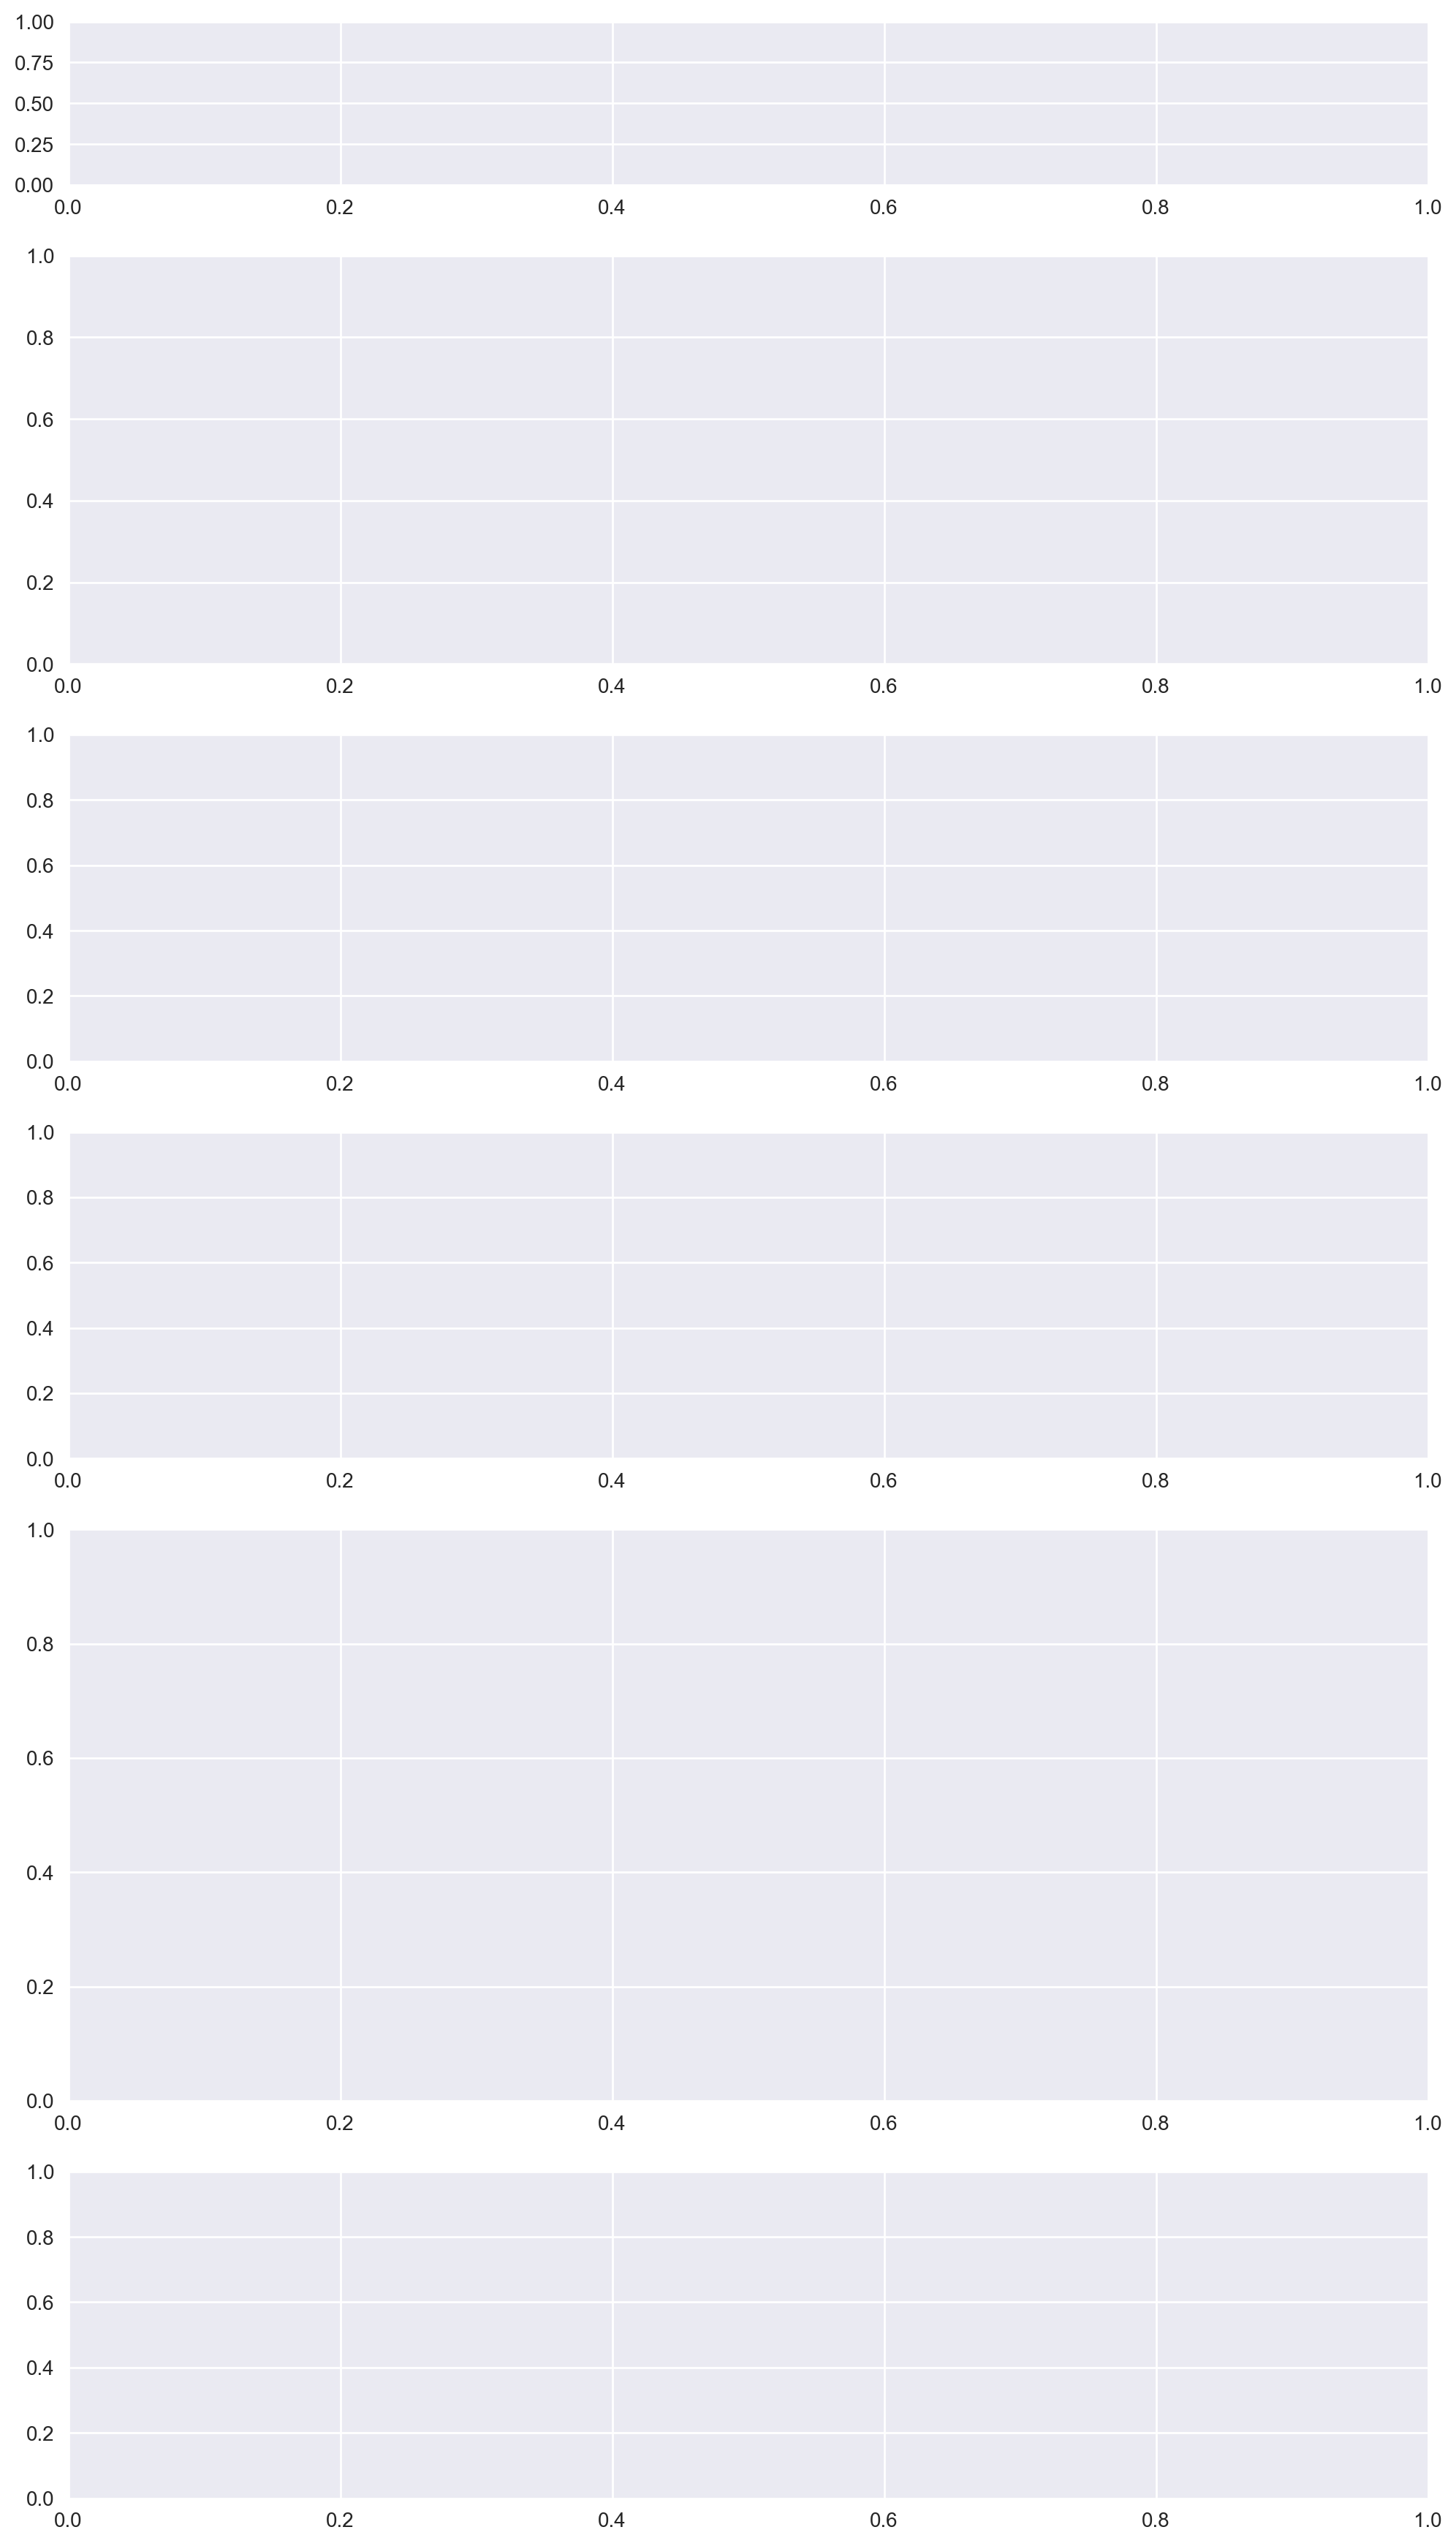

In [ ]:
# plot the results
model.plot_simulation_records(manual_update=True)

In [48]:
display(df)


0          1          2          3          4  \
0              0.989828   0.985696   0.989219   0.989661   0.989661   
1              0.989828   0.985696   0.989219   0.989661   0.989661   
2              0.989828   0.985823   0.989219   0.989661   0.989661   
3              0.989828   0.985823   0.989219   0.989661   0.989661   
4              0.989310   0.985190   0.989219   0.989492   0.988136   
...                 ...        ...        ...        ...        ...   
96             0.989828   0.985823   0.989219   0.989661   0.989661   
97             0.989828   0.985696   0.989219   0.989661   0.989661   
98             0.989828   0.985823   0.989219   0.989661   0.989492   
99             0.989138   0.987848   0.989688   0.989831   0.989492   
sample_count  58.000000  79.000000  64.000000  59.000000  59.000000   

                      5          6          7          8          9  max_index  
0              0.989216   0.989630   0.989032   0.989388   0.989538          0  
1              0.989216   0.989630   0.989032   0.989388   0.989538          0  
2              0.989216   0.989630   0.989194   0.989592   0.989538          0  
3              0.989412   0.989815   0.989032   0.989388   0.989538          0  
4              0.988431   0.989074   0.988226   0.989592   0.989385          8  
...                 ...        ...        ...        ...        ...        ...  
96             0.989216   0.989630   0.989032   0.989592   0.989385          0  
97             0.989412   0.989815   0.989032   0.989388   0.989538          0  
98             0.989412   0.989630   0.989032   0.989388   0.989538          0  
99             0.989412   0.989444   0.988871   0.989796   0.989538          3  
sample_count  51.000000  54.000000  62.000000  49.000000  65.000000          1  

[101 rows x 11 columns]

In [1]:
model.plot_simulation_records2()

NameError: name 'model' is not defined